# Demo: 3x5mm Right Hemisphere FOV
Estimating the reliable dimensionality of neuronal population dynamics as a function of neuron number

This example will walk you through a number of analyses from [Manley et al. _Neuron_ 2024](https://doi.org/10.1016/j.neuron.2024.02.011).
Namely:

1. Utilizing SVCA to estimate the reliable dimensionality of neuronal population dynamics as a function of neuron number
2. Predicting neural SVC dimensions from behavioral variables
3. Quantifying the timescales of neural SVC dimensions
4. Quantifying the spatial distribution of neural SVC dimensions

The data analyzed here are freely available at https://doi.org/10.5281/zenodo.10403684.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from rastermap import Rastermap
from scipy.stats import zscore
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

import scaling_analysis as sa
from scaling_analysis.experiment import Experiment
from scaling_analysis.plotting import set_my_rcParams, plot_MIPs, plot_neurons_behavior, calc_var_expl
from scaling_analysis.predict import predict_from_behavior
from scaling_analysis.spatial import local_homogeneity
from scaling_analysis.temporal import compute_timescales

set_my_rcParams()

The `Experiment` class loads the example .h5 files provided.

In [2]:
path = "/path/to/example/data/"
file = "20210310_right_hemisphere_289mW_50_550um_depth_60min_no_stim.h5"
expt = Experiment(os.path.join(path, file))

Loading example data 20210310_right_hemisphere_289mW_50_550um_depth_60min_no_stim.h5


In [3]:
# z-scored neural data
neurons = zscore(expt.T_all.astype('single'))
print(file, "contains", neurons.shape[1], "neurons and", neurons.shape[0], "timepoints")
centers = expt.centers # neuron x,y,z positions

# z-scored facial videography behavior data
motion = zscore(expt.motion.astype('single')) * 10
print(file, "contains", motion.shape[1], "behavior PCs and", motion.shape[0], "timepoints")

Y = expt.Y # MIP of recording
fhz = expt.fhz # volume rate
t = expt.t # timestamps (in seconds)
treadmill_velocity = expt.velocity_events

del expt

20210310_right_hemisphere_289mW_50_550um_depth_60min_no_stim.h5 contains 204798 neurons and 17280 timepoints
20210310_right_hemisphere_289mW_50_550um_depth_60min_no_stim.h5 contains 500 behavior PCs and 17280 timepoints


To reduce the computational complexity for these examples, let's randomly sample some number of neurons from this large dataset.

In [4]:
max_nneur = 131072
rng = np.random.default_rng(seed=138)
idx = rng.permutation(neurons.shape[1])[:max_nneur]

neurons = neurons[:,idx]
centers = centers[:,idx]

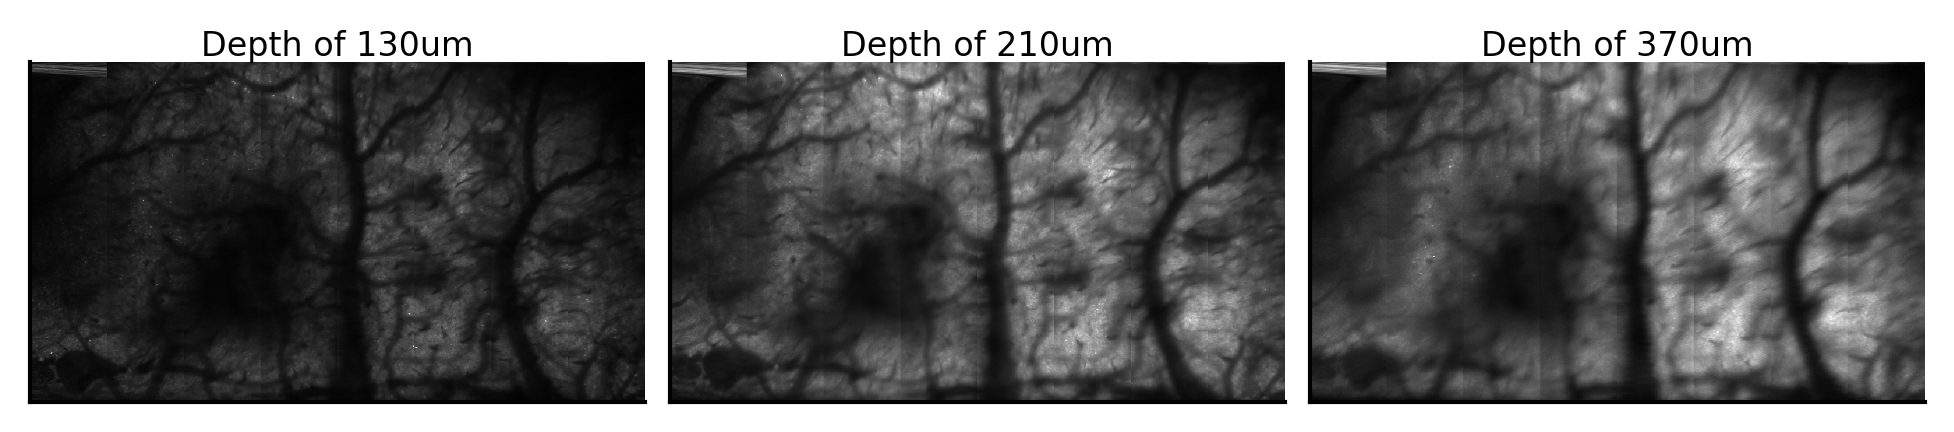

In [5]:
# PLOT MAXIMUM INTENSITY PROJECTIONS OF FOV

plot_MIPs(Y)

In [6]:
# PLOT EXAMPLE NEURAL AND BEHAVIORAL DYNAMICS

min_start = 3 # minutes
min_stop = 6 # minutes

t_idx = np.arange(int(fhz * min_start * 60),
                  int(fhz * min_stop * 60))

neurons_example = zscore(neurons[t_idx,:])
motion_example = zscore(motion[t_idx, :3])

model = Rastermap(n_PCs=32, n_clusters=8).fit(neurons_example.T)

normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.95sec
sorting activity: 131072 valid samples by 864 timepoints
n_PCs = 32 computed, 8.13sec
8 clusters computed, time 10.45sec
clusters sorted, time 10.48sec
clusters upsampled, time 10.59sec
rastermap complete, time 10.61sec


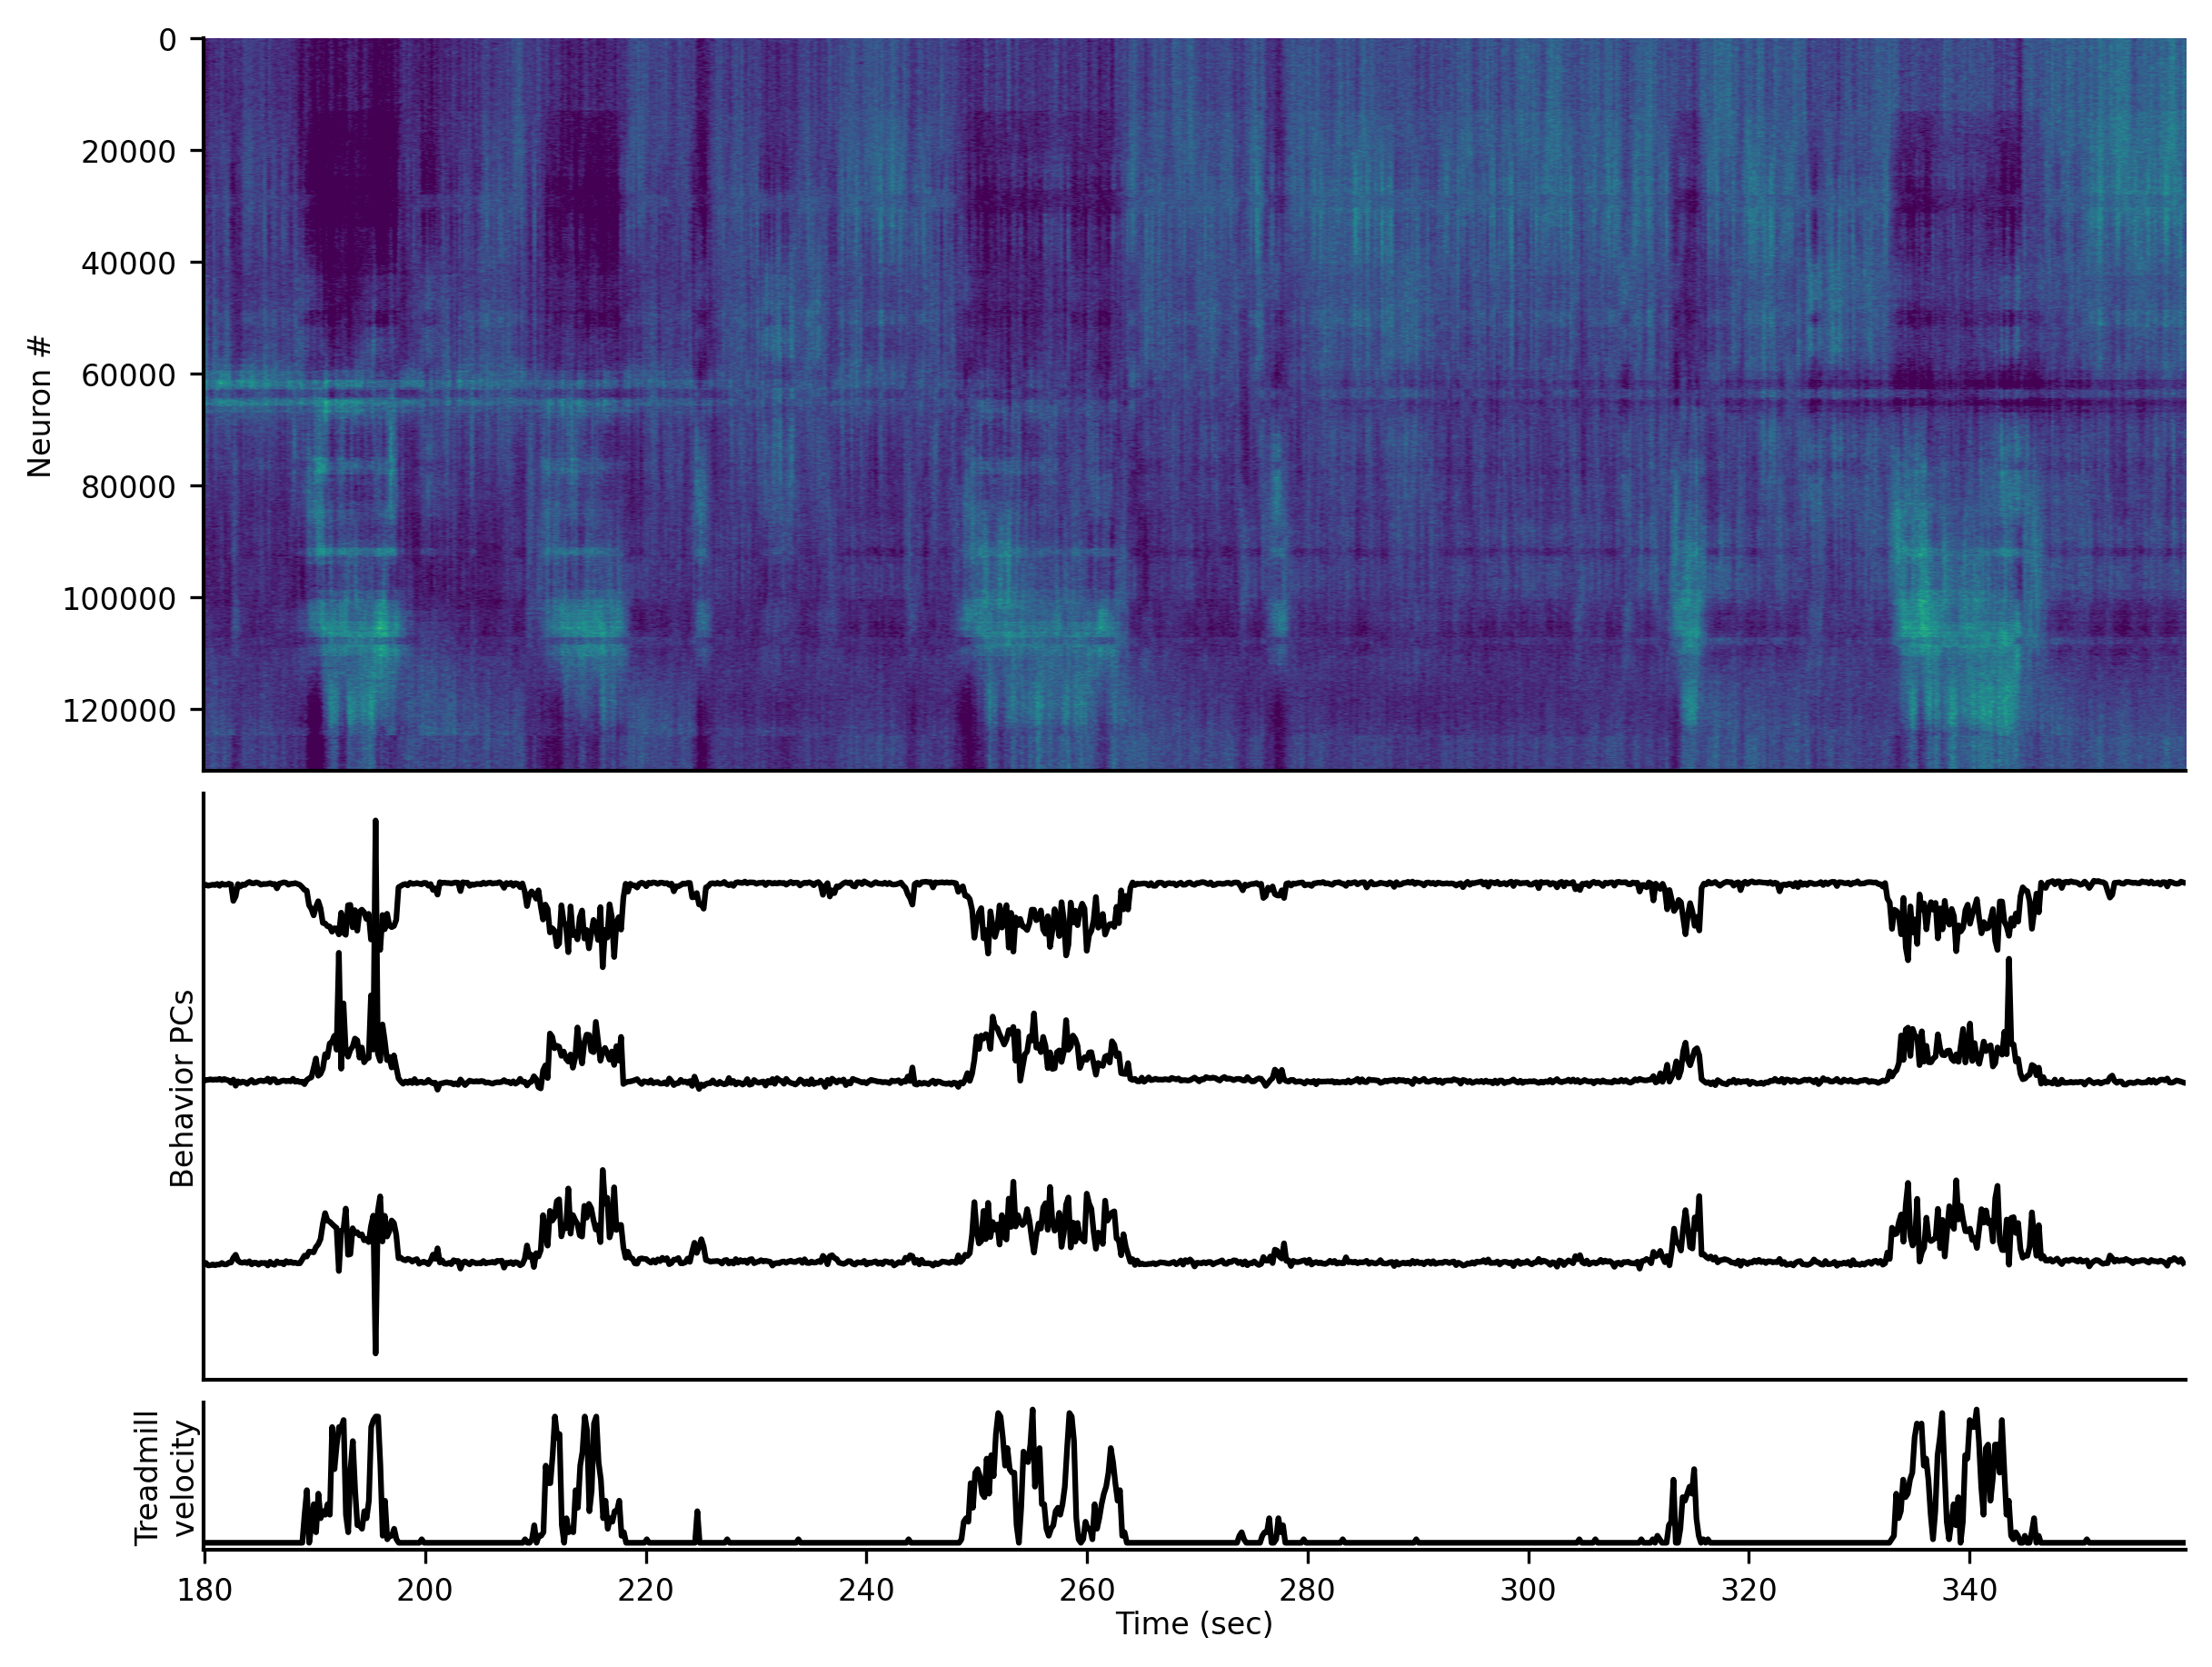

In [7]:
plot_neurons_behavior(neurons_example[:,model.isort], motion_example,
                      treadmill_velocity[t_idx], t[t_idx], clim=[-0.3, 1.2]);

## SVCA on varying neuron numbers

In [8]:
# PARAMETERS
# Note: these analyses can take quite some time to run for large neuron numbers
# Reduce nneurs, nsamplings, nsvc, and/or nsvc_predict for smaller, efficient tests
nneurs = 2 ** np.arange(8,18)   # numbers of neurons to sample
checkerboard = 250              # size of lateral checkerboard pattern to split neural sets, in um
nsamplings = 3                  # number of samplings to perform
lag = -1                        # lag between motion and neural data, in frames
interleave = int(72*fhz)        # length of chunks that are randomly assigned to training or testing, in frames
nsvc = 512                      # number of SVCs to find
nsvc_predict = 64               # number of SVCs to predict from behavior
lams = [0.01, 0.1]              # regularization parameters for reduced rank regression of neural SVCs
ranks = np.unique(np.round(     # ranks to test in reduced rank regression of neural SVCs
    2 ** np.arange(2,8))
                 ).astype(int)

MLPregressor = False             # whether or not to fit MLP nonlinear model
prePCA = False                   # whether or not to perform PCA before running SVCA
                                 #         (saves memory for large neuron number, but takes longer)

In [9]:
cov_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

for n in range(len(nneurs)):
    print(nneurs[n], 'NEURONS')
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(neurons, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)
    
    cov_neurs[n,:] = cov_neur
    var_neurs[n,:] = var_neur
    cov_res_behs[n,:] = cov_res_beh
    
    ex_u.append(u)
    ex_v.append(v)
    ex_ntrain.append(ntrain)
    ex_ntest.append(ntest)
    ex_itrain.append(itrain)
    ex_itest.append(itest)

256 NEURONS


100%|██████████| 3/3 [00:58<00:00, 19.64s/it]


512 NEURONS


100%|██████████| 3/3 [01:03<00:00, 21.17s/it]


1024 NEURONS


100%|██████████| 3/3 [01:07<00:00, 22.53s/it]


2048 NEURONS


100%|██████████| 3/3 [01:08<00:00, 22.89s/it]


4096 NEURONS


100%|██████████| 3/3 [01:14<00:00, 24.79s/it]


8192 NEURONS


100%|██████████| 3/3 [01:15<00:00, 25.31s/it]


16384 NEURONS


100%|██████████| 3/3 [01:50<00:00, 36.85s/it]


32768 NEURONS


100%|██████████| 3/3 [02:42<00:00, 54.03s/it]


65536 NEURONS


100%|██████████| 3/3 [05:41<00:00, 113.71s/it]


131072 NEURONS


100%|██████████| 3/3 [18:06<00:00, 362.08s/it]


### Shuffling tests

In [10]:
# Compute shuffled SVCs

nsamplings_shuff = 5 # ideally we'd want more to get a good sense
                     # of the distribution of shuffled coefficients

cov_neurs_shuff = np.zeros((nsvc, nsamplings_shuff))+np.nan
var_neurs_shuff = np.zeros((nsvc, nsamplings_shuff))+np.nan
cov_res_behs_shuff = np.zeros((nsvc_predict, len(ranks), len(lams), nsamplings_shuff))+np.nan

ex_u_shuff = []
ex_v_shuff = []
ex_ntrain_shuff = []
ex_ntest_shuff = []
ex_itrain_shuff = []
ex_itest_shuff = []

# Run predict_from_behavior many times with 1 sampling each,
# so that we save the example u, v, etc. every time we run SVCA
for i in range(nsamplings_shuff):
    print("SAMPLING", i+1, "OUT OF", nsamplings_shuff)
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(neurons, nneurs[-1], centers, motion, ranks, nsamplings=1, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave, shuffle=True)
    
    cov_neurs_shuff[:,i] = cov_neur[:,0]
    var_neurs_shuff[:,i] = var_neur[:,0]
    cov_res_behs_shuff[:,i] = cov_res_beh[:,0]
    
    ex_u_shuff.append(u)
    ex_v_shuff.append(v)
    ex_ntrain_shuff.append(ntrain)
    ex_ntest_shuff.append(ntest)
    ex_itrain_shuff.append(itrain)
    ex_itest_shuff.append(itest)

SAMPLING 1 OUT OF 5


100%|██████████| 1/1 [05:53<00:00, 353.16s/it]


SAMPLING 2 OUT OF 5


100%|██████████| 1/1 [07:38<00:00, 458.96s/it]


SAMPLING 3 OUT OF 5


100%|██████████| 1/1 [20:13<00:00, 1213.75s/it]


SAMPLING 4 OUT OF 5


100%|██████████| 1/1 [07:49<00:00, 469.92s/it]


SAMPLING 5 OUT OF 5


100%|██████████| 1/1 [07:55<00:00, 475.56s/it]


### The reliable dimensionality scales in an unbounded fashion with the number of randomly sampled neurons

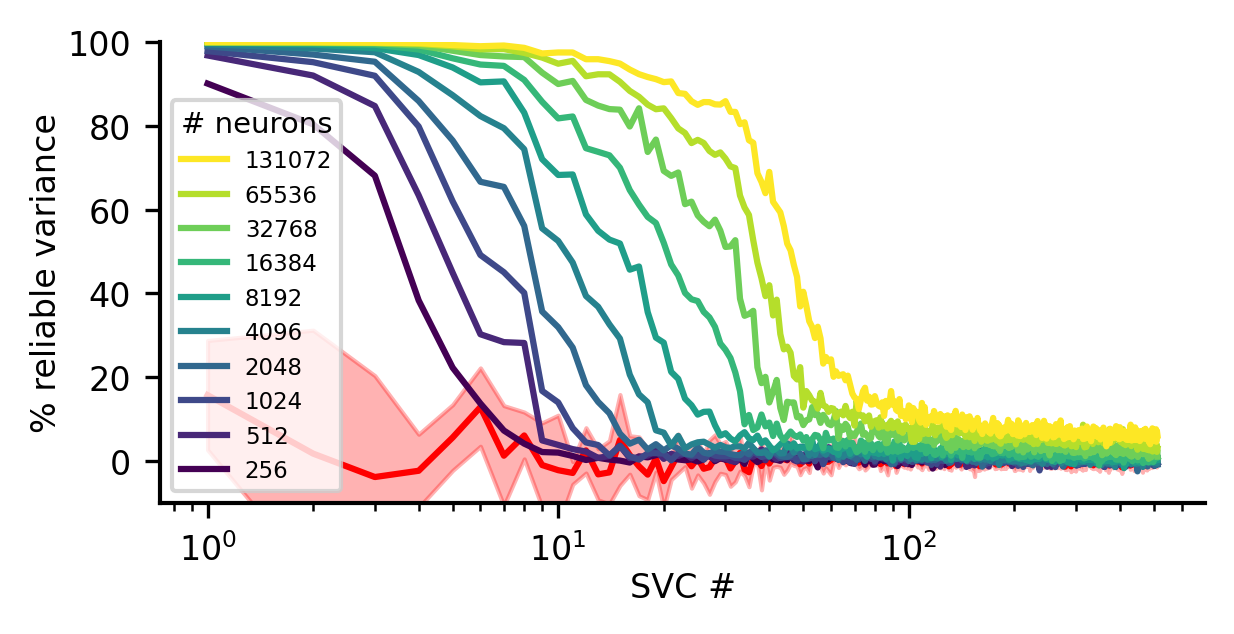

In [11]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xscale('log');

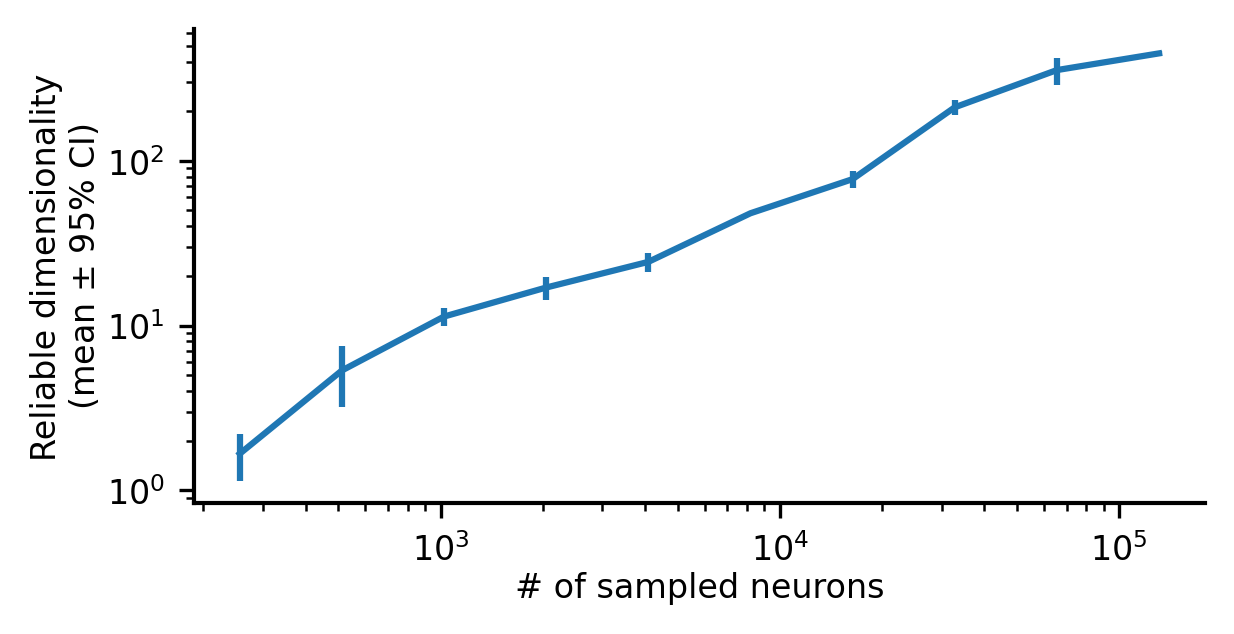

In [12]:
# PLOT # RELIABLE SVCS VS. NNEUR

# thresh = 0.2 # can also compare to a manual threshold
# ideally, we'd have thresholds for each neuron number
# however we only computed shuffled SVCs for the largest neuron number!
n_sigma = 4
thresh = relvar_shuff + n_sigma * relvar_shuff_std
thresh = thresh[np.newaxis,:,np.newaxis]

reldim = np.nanmean(np.nansum((cov_neurs/var_neurs)>thresh,axis=1),axis=-1)
ci95 = np.nanstd(np.nansum((cov_neurs/var_neurs)>thresh,axis=1),axis=-1)/np.sqrt(nsamplings)*1.96

plt.figure(figsize=(4,2))
plt.errorbar(nneurs, reldim, ci95)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of sampled neurons')
plt.ylabel('Reliable dimensionality\n(mean $\\pm$ 95% CI)');

## Predictability of neural SVCs from behavior videography

### Only the few largest neural SVCs are predictable from instantaneous behavior

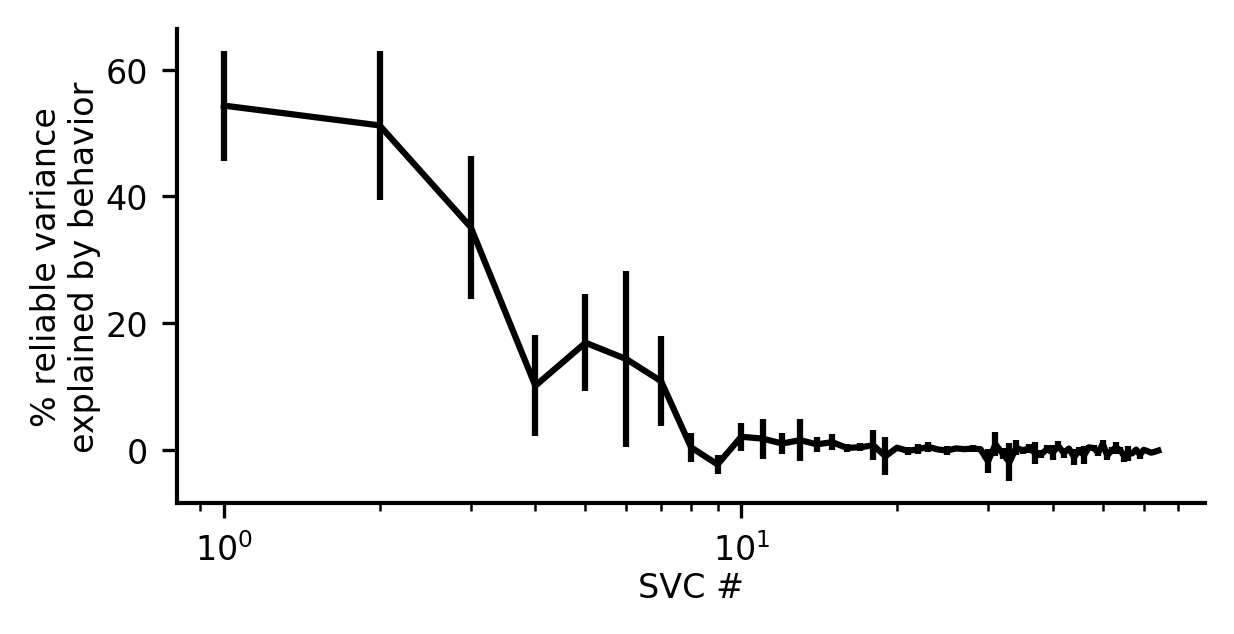

In [13]:
# PLOT VAR. EXPL. BY BEHAVIOR VS. SVC #

varexpl_per_sampling = calc_var_expl(cov_neurs, var_neurs, cov_res_behs)
varexpl = np.nanmean(varexpl_per_sampling, axis=-1)
ci95 = np.nanstd(varexpl_per_sampling, axis=-1)/np.sqrt(nsamplings)*1.96

plt.figure(figsize=(4,2))
plt.errorbar(np.arange(nsvc_predict)+1, varexpl[-1,:]*100, ci95[-1,:]*100, color='k')
plt.xlabel('SVC #')
plt.ylabel('% reliable variance\nexplained by behavior')
plt.xscale('log');

#### The fraction of neural variance explained by behavior saturates at ~10,000 neurons

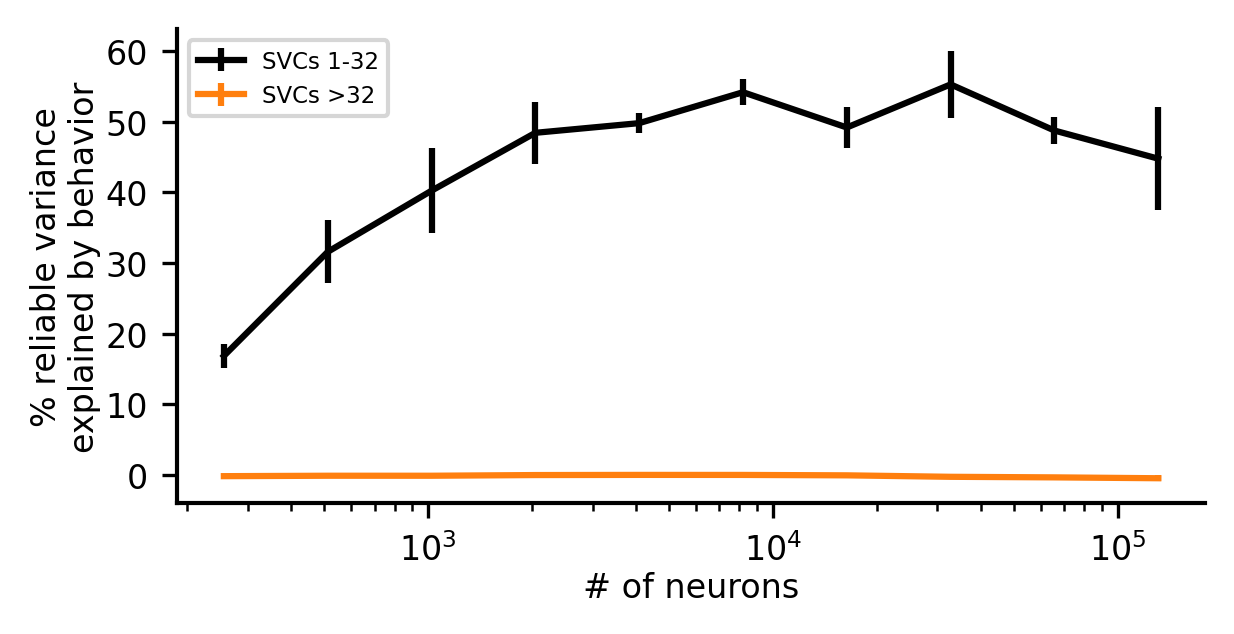

In [14]:
# PLOT VAR. EXPL. BY BEHAVIOR VS. NEURON NUMBER

low_pcs = range(32)

varexpl_per_sampling = calc_var_expl(cov_neurs[:,low_pcs,:], var_neurs[:,low_pcs,:], cov_res_behs[:,low_pcs,:], cumulative=True)
varexpl_vs_nneur_low = np.nanmean(varexpl_per_sampling, axis=-1)
ci95_low = np.nanstd(varexpl_per_sampling, axis=-1)/np.sqrt(nsamplings)*1.96

high_pcs = range(32,nsvc_predict)

varexpl_per_sampling = calc_var_expl(cov_neurs[:,high_pcs,:], var_neurs[:,high_pcs,:], cov_res_behs[:,high_pcs,:], cumulative=True)
varexpl_vs_nneur_high = np.nanmean(varexpl_per_sampling, axis=-1)
ci95_high = np.nanstd(varexpl_per_sampling, axis=-1)/np.sqrt(nsamplings)*1.96

plt.figure(figsize=(4,2))
plt.errorbar(nneurs, varexpl_vs_nneur_low[:,-1]*100, ci95_low[:,-1]*100, color='k')
plt.errorbar(nneurs, varexpl_vs_nneur_high[:,-1]*100, ci95_high[:,-1]*100, color=plt.cm.tab10(1))
plt.xscale('log')
plt.legend(['SVCs 1-32','SVCs >32'])
plt.xlabel('# of neurons')
plt.ylabel('% reliable variance\nexplained by behavior');

## Autocorrelation timescales of neural SVCs

In [15]:
# Compute autocorrelation timescales for each neuron number

timescales = np.zeros((nsvc, len(nneurs)))+np.nan

for i in tqdm(range(len(nneurs))):
    svcs = neurons[:,ex_ntrain[i]] @ ex_u[i]
    _, curr_timescales, _ = compute_timescales(svcs, t)
    timescales[:len(curr_timescales),i] = curr_timescales

100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


### Neural SVCs exhibit a continuum of timescales

/var/folders/44/wxb14ysx2zg17xfp0hkwzmjm0000gn/T/ipykernel_29054/3100988667.py:8: RuntimeWarning: Mean of empty slice
  relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)


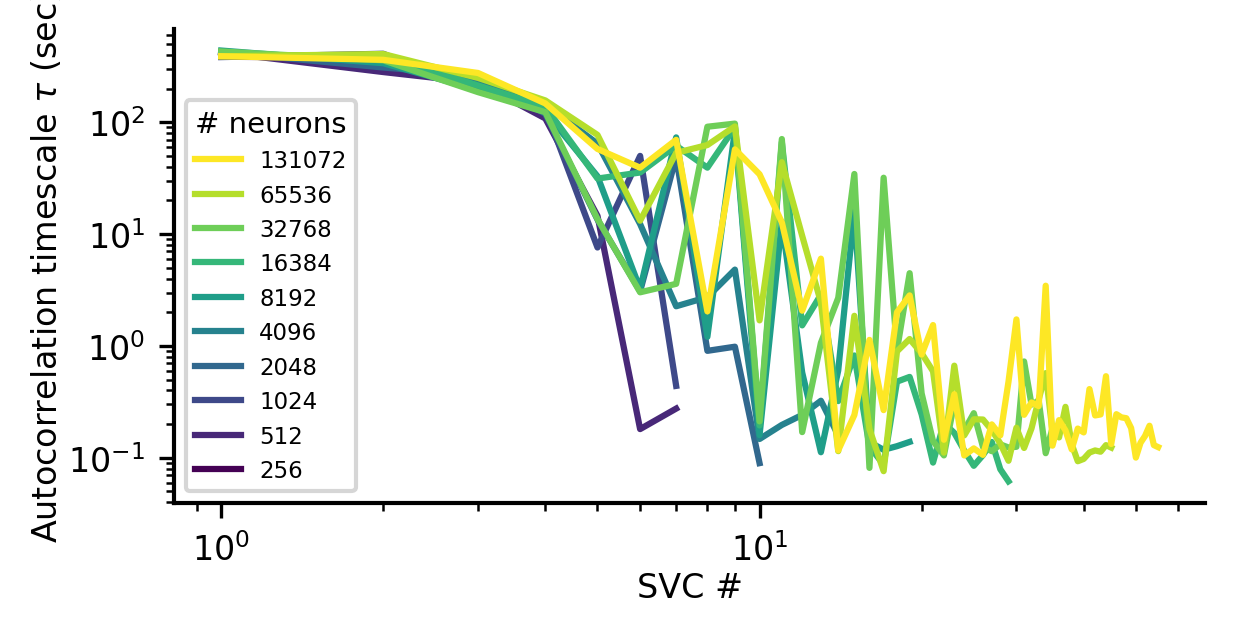

In [16]:
# PLOT AUTOCORRELATION TIMESCALES VS. NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    idx_reliable = np.where(relvar > 0.25)[0]
    nplot = idx_reliable[-1]
    l,=plt.plot(np.arange(nplot)+1, timescales[:nplot,n], color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('Autocorrelation timescale $\\tau$ (sec)')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.xscale('log')
plt.yscale('log');

## Spatial distribution of neural SVCs

For a simple example, here we'll just plot the spatial distribution of the top 3% of neurons contributing to each SVC, based on their coefficients. See [Manley et al.](https://doi.org/10.1016/j.neuron.2024.02.011) for a more principled approach: consider a neuron participating if its coefficient is significantly greater than its distribution of coefficients from shuffled. This latter approach requires enough samplings of shuffled SVCs to accurately capture the shuffled distribution.

In [17]:
nneuri = len(nneurs)-1       # which neuron # to analyze
percentile = 0.03            # top percent of neurons considered "participating" in SVC
dists = [20,50,100,250,500]  # radial distances (um) to measure homogeneity
nspatial = 100               # number of neurons to compute their local homogeneity

ex_svc = np.concatenate((ex_u[nneuri], ex_v[nneuri]))
ex_idx = np.concatenate((ex_ntrain[nneuri], ex_ntest[nneuri]))

u_neurnorm = np.abs(ex_svc)/np.sum(np.abs(ex_svc), axis=1).reshape(-1,1)
idxsort = np.argsort(u_neurnorm, axis=0)
ucenters = centers[:,ex_idx]

homogeneity = np.zeros((nsvc,len(dists),nspatial))+np.nan

for i in tqdm(range(nsvc)):
    idxbig = idxsort[:,i][-int(percentile*u_neurnorm.shape[0]):]
    binary = np.zeros((u_neurnorm.shape[0],))
    binary[idxbig] = True
    
    curr = local_homogeneity(binary, ucenters, dist_threshes=dists, ntodo=nspatial)
    homogeneity[i,:,:curr.shape[0]] = curr.T

  0%|          | 0/512 [00:00<?, ?it/s]/Users/jmanley/Documents/miniconda3/envs/testpc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jmanley/Documents/miniconda3/envs/testpc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 512/512 [00:25<00:00, 20.16it/s]


### Lower (behavior-related) neural SVCs are spatially clustered

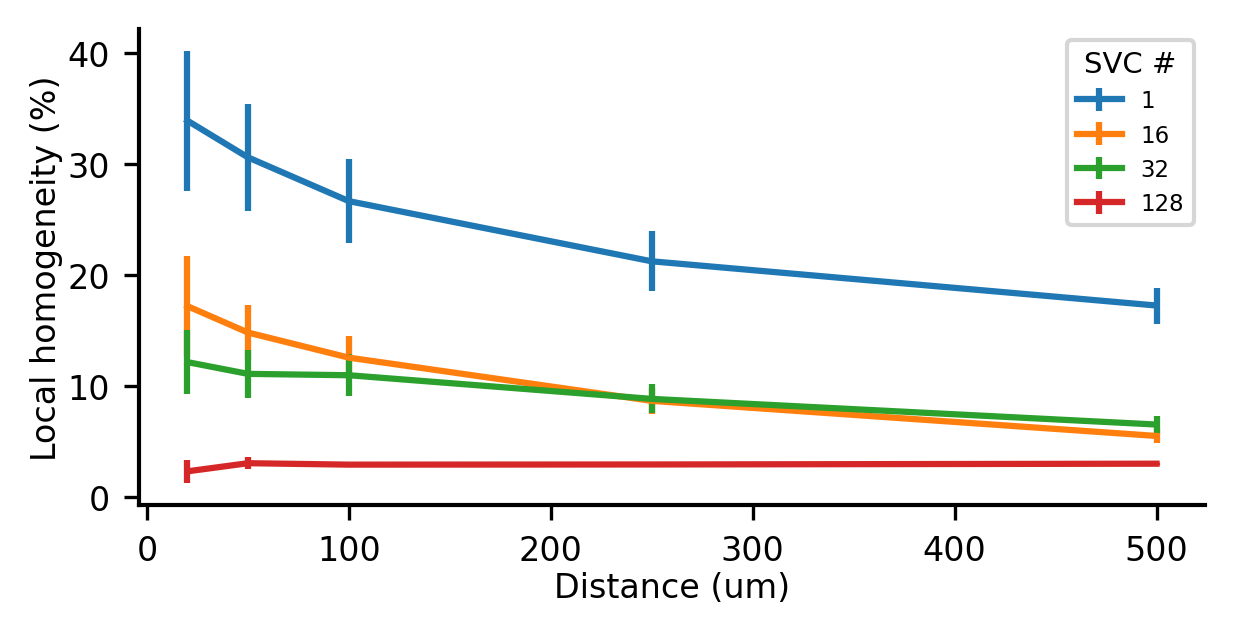

In [25]:
svcs_to_plot = [0,15,31,127]

plt.figure(figsize=(4,2))
for i in range(len(svcs_to_plot)):
    hom = np.nanmean(homogeneity[svcs_to_plot[i],:],axis=-1)*100
    ci95 = np.nanstd(homogeneity[svcs_to_plot[i],:],axis=-1)*100/np.sqrt(homogeneity.shape[-1])*1.96
    plt.errorbar(dists,hom,ci95,color=plt.cm.tab10(i))

plt.xlabel('Distance (um)')
plt.ylabel('Local homogeneity (%)')
plt.legend(np.asarray(svcs_to_plot)+1, title='SVC #')

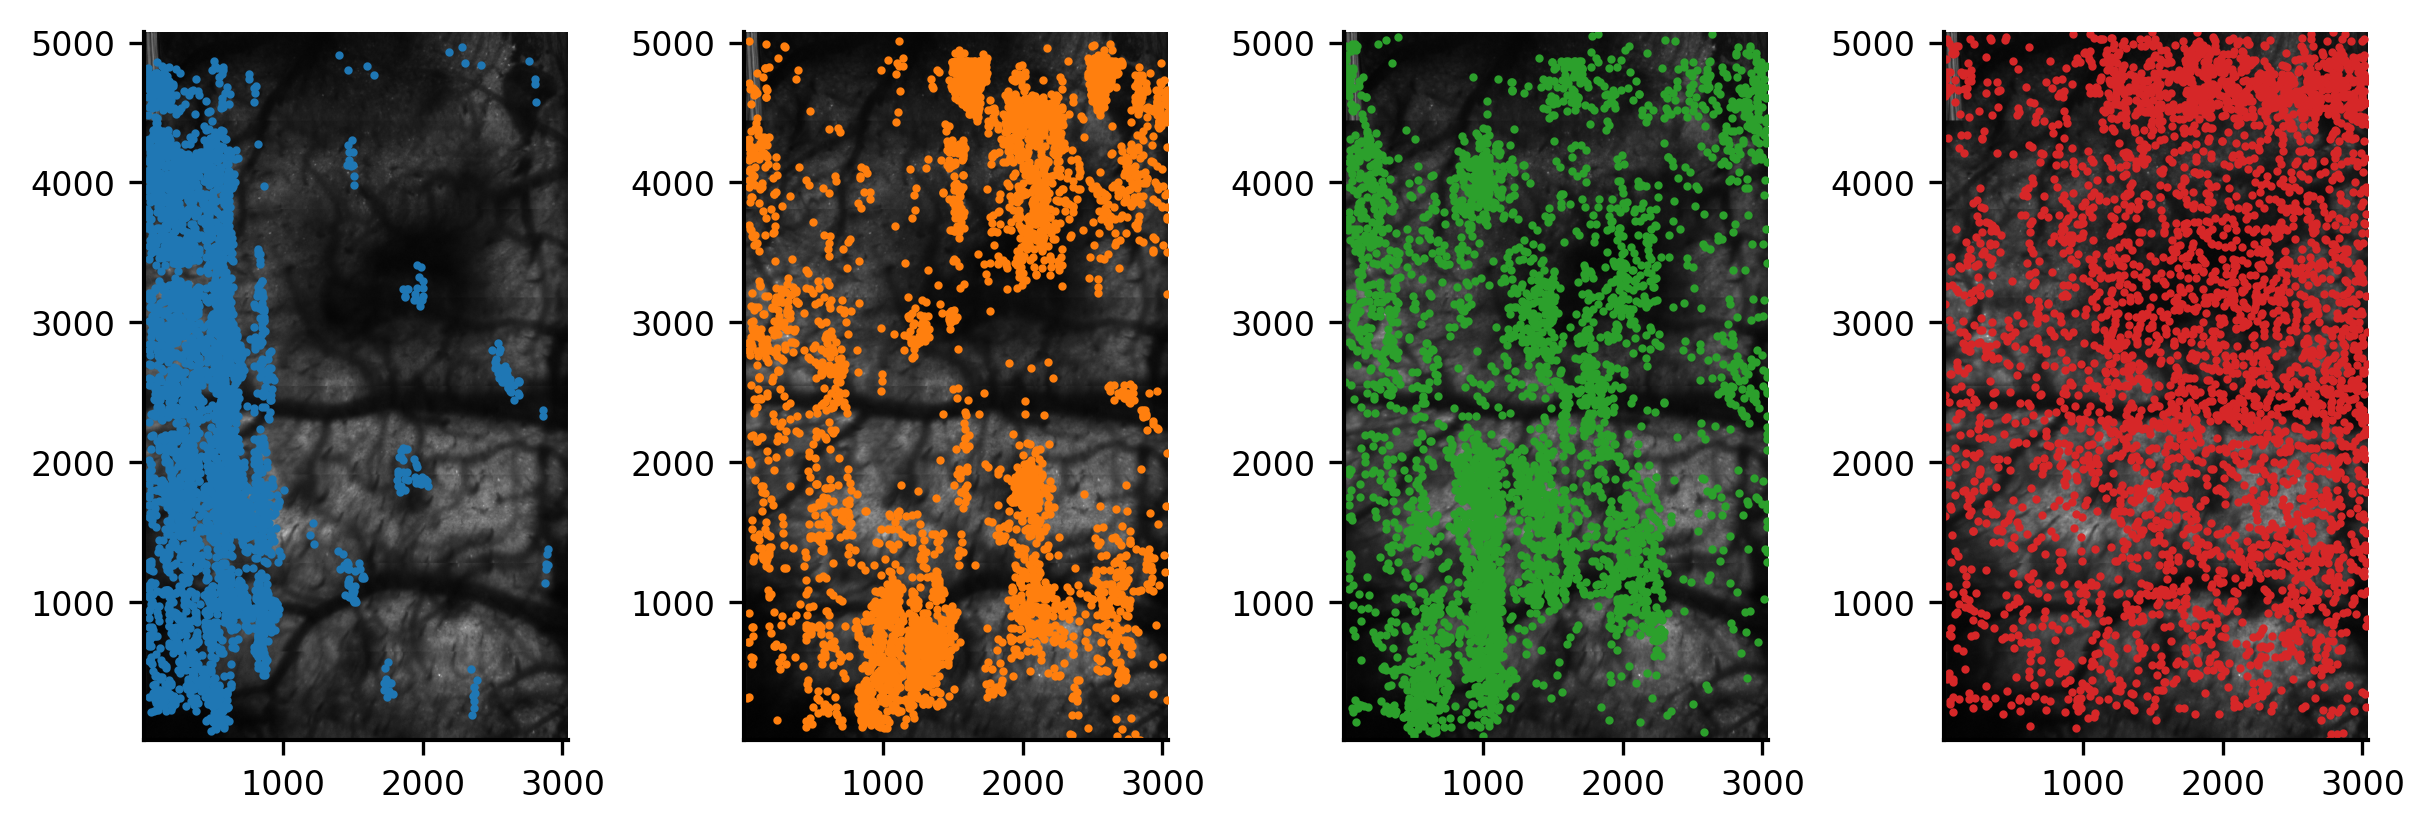

In [26]:
plt.figure(figsize=(8,4))
for i in range(len(svcs_to_plot)):
    plt.subplot(1,len(svcs_to_plot),i+1)
    idxbig = idxsort[:,svcs_to_plot[i]][-int(percentile*u_neurnorm.shape[0]):]
    
    plt.imshow(Y[:,:,6].T, 
               extent=[np.min(centers[0,:]), np.max(centers[0,:]), np.min(centers[1,:]), np.max(centers[1,:])])
    plt.scatter(ucenters[0,idxbig], ucenters[1,idxbig], 1, color=plt.cm.tab10(i))

Text(0.5, 0, 'SVC #')

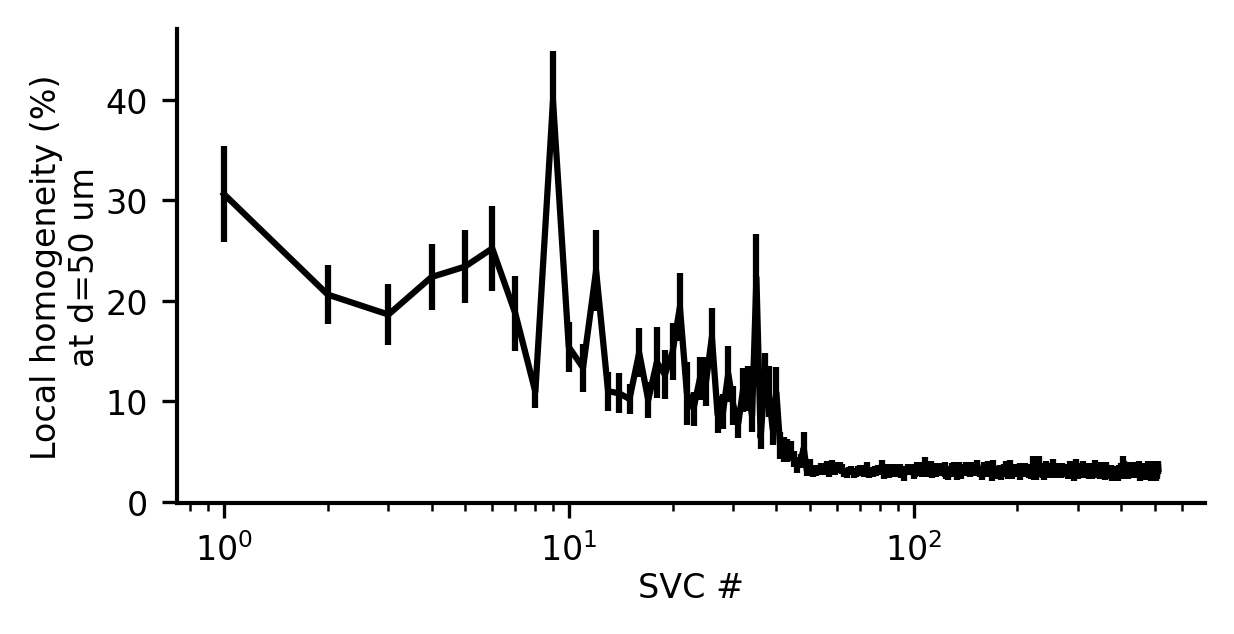

In [27]:
di = 1
hom = np.nanmean(homogeneity[:,di,:],axis=-1)*100
ci95 = np.nanstd(homogeneity[:,di,:],axis=-1)*100/np.sqrt(homogeneity.shape[-1])*1.96

plt.figure(figsize=(4,2))
plt.errorbar(np.arange(homogeneity.shape[0])+1, hom, ci95, color='k')
plt.xscale('log')

plt.ylabel('Local homogeneity (%)\nat d='+str(dists[di])+' um')
plt.xlabel('SVC #')